<a href="https://colab.research.google.com/github/mohamedshouaib/iti/blob/main/Computer_Vision%20/Day02/Faster_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/mohamedshouaib/iti.git
!cd iti/Computer_Vision/Day02

Cloning into 'iti'...
remote: Enumerating objects: 2426, done.
remote: Counting objects: 100% (1735/1735), done.
remote: Compressing objects: 100% (977/977), done.
remote: Total 2426 (delta 132), reused 5 (delta 5), pack-reused 691 (from 2)
Receiving objects: 100% (2426/2426), 124.28 MiB | 25.18 MiB/s, done.
Resolving deltas: 100% (302/302), done.
Updating files: 100% (1857/1857), done.


In [5]:
import torch
import torchvision.transforms as T
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50
import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign, box_iou
import torch.optim as optim
from tqdm import tqdm

In [6]:
BATCH_SIZE = 2
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005
NUM_EPOCHS = 25
PATIENCE = 5
ANCHOR_SIZES = ((32, 64, 128, 256, 512),)
ASPECT_RATIOS = ((0.5, 1.0, 2.0),)
IOU_THRESHOLD = 0.5

In [7]:
class Load_Dataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms

        self.valid_samples = []
        for img_name in sorted(os.listdir(image_dir)):
            if not img_name.lower().endswith(('.jpg', '.png', '.jpeg', '.tif')):
                continue

            label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")
            if not os.path.exists(label_path):
                continue

            with open(label_path, 'r') as f:
                has_valid_boxes = False
                for line in f:
                    parts = line.strip().replace(",", " ").split()
                    if len(parts) == 4:
                        x1, y1, x2, y2 = map(int, parts)
                        if x2 > x1 and y2 > y1:
                            has_valid_boxes = True
                            break

            if has_valid_boxes:
                self.valid_samples.append(img_name)

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        img_name = self.valid_samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + ".txt")

        img = Image.open(img_path).convert("RGB")

        boxes = []
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().replace(",", " ").split()
                if len(parts) == 4:
                    x1, y1, x2, y2 = map(int, parts)
                    if x2 > x1 and y2 > y1:
                        boxes.append([x1, y1, x2, y2])

        if self.transforms:
            img = self.transforms(img)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels}

        return img, target

In [8]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = Load_Dataset("iti/Computer_Vision/Day02/TrainImages", "iti/Computer_Vision/Day02/TrainGroundTruth", transforms=transform)
val_dataset = Load_Dataset("iti/Computer_Vision/Day02/TestImages", "iti/Computer_Vision/Day02/TestGroundTruth", transforms=transform)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

if len(train_dataset) == 0 or len(val_dataset) == 0:
    raise ValueError("No valid training samples found. Check your data paths and label files.")

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

Train samples: 660
Validation samples: 115


In [9]:
class MyFasterRCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        backbone = resnet50(weights=None)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])
        self.backbone.out_channels = 2048

        anchor_generator = AnchorGenerator(
            sizes=ANCHOR_SIZES,
            aspect_ratios=ASPECT_RATIOS
        )

        roi_pooler = MultiScaleRoIAlign(
            featmap_names=['0'],
            output_size=7,
            sampling_ratio=2
        )

        self.model = FasterRCNN(
            backbone=self.backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )

    def forward(self, images, targets=None):
        return self.model(images, targets)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyFasterRCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [7]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    total_loss = 0
    for images, targets in tqdm(data_loader, desc="Training"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        total_loss += losses.item()
    return total_loss / len(data_loader)


In [8]:
def validate(model, data_loader, device):
    model.train()
    val_loss = 0
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Validating"):
            if not images or not targets:
                continue

            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

    model.eval()
    return val_loss / len(data_loader) if len(data_loader) > 0 else 0


In [9]:
def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    total_acc = 0
    total_images = 0

    def compute_iou(pred_boxes, gt_boxes):
        if len(gt_boxes) == 0:
            return 1.0 if len(pred_boxes) == 0 else 0.0
        if len(pred_boxes) == 0:
            return 0.0
        ious = box_iou(pred_boxes, gt_boxes)
        matched_gt = set()
        correct = 0
        for i in range(len(pred_boxes)):
            max_iou, max_j = ious[i].max(0)
            if max_iou.item() > iou_threshold and max_j.item() not in matched_gt:
                matched_gt.add(max_j.item())
                correct += 1
        return correct / len(gt_boxes)

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)
            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"].cpu()
                gt_boxes = target["boxes"].cpu()
                acc = compute_iou(pred_boxes, gt_boxes)
                total_acc += acc
                total_images += 1

    return total_acc / total_images if total_images > 0 else 0

In [10]:
train_losses = []
val_losses = []
best_loss = float('inf')
patience = 3
counter = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    train_losses.append(train_loss)

    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'iti/Computer_Vision/Day02/best_model.pth')
        print("Saved new best model")
    else:
        counter += 1
        print(f"No improvement for {counter} epoch(s)")

    if counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.52it/s]


Epoch 1/25 - Train Loss: 0.2708, Val Loss: 0.0732, LR: 0.001000
Saved new best model


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.47it/s]


Epoch 2/25 - Train Loss: 0.0718, Val Loss: 0.0665, LR: 0.001000
Saved new best model


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.50it/s]


Epoch 3/25 - Train Loss: 0.0601, Val Loss: 0.0568, LR: 0.001000
Saved new best model


Validating: 100%|██████████| 58/58 [00:13<00:00,  4.41it/s]


Epoch 4/25 - Train Loss: 0.0559, Val Loss: 0.0518, LR: 0.001000
Saved new best model


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.48it/s]


Epoch 5/25 - Train Loss: 0.0547, Val Loss: 0.0502, LR: 0.001000
Saved new best model


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.46it/s]


Epoch 6/25 - Train Loss: 0.0548, Val Loss: 0.0512, LR: 0.001000
No improvement for 1 epoch(s)


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.47it/s]


Epoch 7/25 - Train Loss: 0.0486, Val Loss: 0.0488, LR: 0.001000
Saved new best model


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.47it/s]


Epoch 8/25 - Train Loss: 0.0460, Val Loss: 0.0478, LR: 0.001000
Saved new best model


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


Epoch 9/25 - Train Loss: 0.2018, Val Loss: 0.0884, LR: 0.001000
No improvement for 1 epoch(s)


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.58it/s]


Epoch 10/25 - Train Loss: 0.4605, Val Loss: 0.0895, LR: 0.001000
No improvement for 2 epoch(s)


Validating: 100%|██████████| 58/58 [00:12<00:00,  4.56it/s]

Epoch 11/25 - Train Loss: 0.3767, Val Loss: 0.0783, LR: 0.001000
No improvement for 3 epoch(s)
Early stopping triggered after 11 epochs.


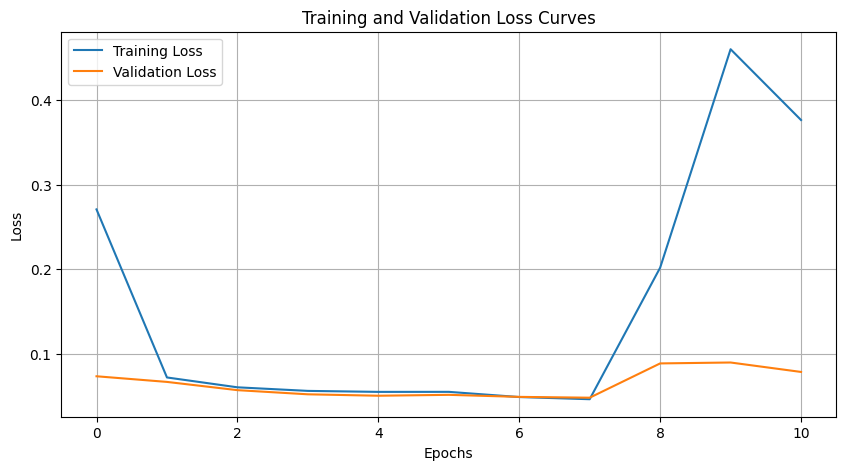

In [11]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

In [10]:
model.load_state_dict(torch.load("iti/Computer_Vision/Day02/best_model.pth"))
accuracy = evaluate_model(model, val_loader, device, IOU_THRESHOLD)
print(f"Model Accuracy (IoU > {IOU_THRESHOLD}): {accuracy:.4f}")

FileNotFoundError: [Errno 2] No such file or directory: 'iti/Computer_Vision/Day02/best_model.pth'

In [1]:
def visualize_predictions(model, image_dir, num_images=5):
    model.eval()
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.tif'))])[num_images:2*num_images]

    for img_name in image_files:
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(img_tensor)

        img_np = np.array(img)
        for box in prediction[0]['boxes'].cpu().numpy():
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)

        plt.figure(figsize=(12, 8))
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(f'Predictions: {img_name}')
        plt.show()

visualize_predictions(model, "iti/Computer_Vision/Day02/TestImages")

NameError: name 'model' is not defined